Columns: ['Trade #', 'Type', 'Date/Time', 'Signal', 'Price INR', 'Position size (qty)', 'Position size (value)', 'Net P&L INR', 'Net P&L %', 'Run-up INR', 'Run-up %', 'Drawdown INR', 'Drawdown %', 'Cumulative P&L INR', 'Cumulative P&L %']
Date column: Date/Time
Close column: Price INR

RandomForest Metrics: {'accuracy': 0.5719844357976653, 'precision': 0.49830508474576274, 'recall': 0.44680851063829785, 'f1': 0.47115384615384615}
GradientBoost Metrics: {'accuracy': 0.5369649805447471, 'precision': 0.4489051094890511, 'recall': 0.3738601823708207, 'f1': 0.4079601990049751}


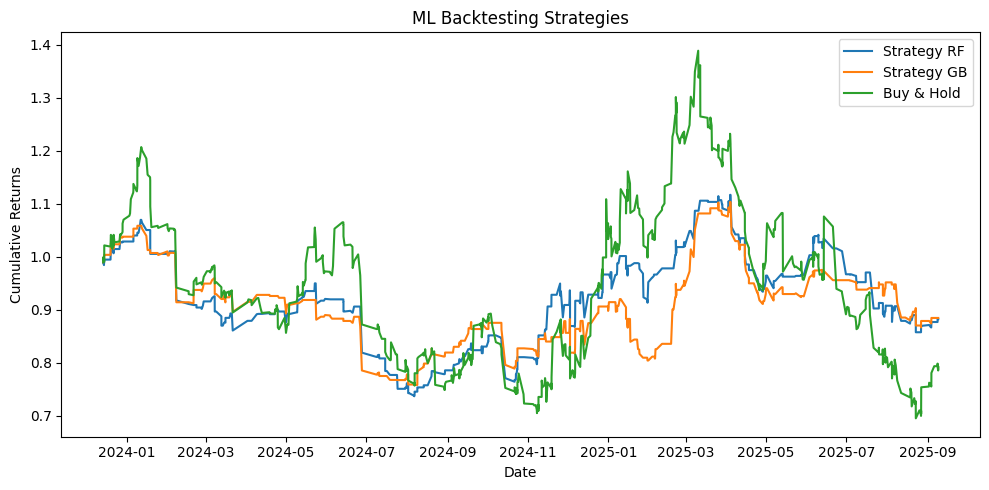

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_excel("/Users/bsharishkumar/dpel/dpel_project/Algo_trading_analysis/Backtesting_report.xlsx", sheet_name=0)
print("Columns:", df.columns.tolist())

# === Detect Date & Price columns ===
date_col = None
close_col = None
for c in df.columns:
    lc = c.lower()
    if 'date' in lc:
        date_col = c
    if 'price' in lc and 'open' not in lc and 'high' not in lc and 'low' not in lc:
        close_col = c

print("Date column:", date_col)
print("Close column:", close_col)

# === Preprocessing ===
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.sort_values(date_col).reset_index(drop=True)
df[close_col] = pd.to_numeric(df[close_col], errors='coerce')
df = df.dropna(subset=[date_col, close_col])

# === Feature Engineering ===
df['return'] = df[close_col].pct_change()
df['return_1'] = df['return'].shift(1)
df['return_2'] = df['return'].shift(2)
df['ma5'] = df[close_col].rolling(window=5).mean().shift(1)
df['ma10'] = df[close_col].rolling(window=10).mean().shift(1)
df['vol5'] = df['return'].rolling(window=5).std().shift(1)
df['momentum_5'] = (df[close_col] / df[close_col].shift(5) - 1).shift(1)

# Targets
df['next_return'] = df['return'].shift(-1)
df['target_up'] = (df['next_return'] > 0).astype(int)

df = df.dropna()

# === Feature Matrix and Labels ===
feature_cols = ['return_1','return_2','ma5','ma10','vol5','momentum_5']
X = df[feature_cols]
y_cls = df['target_up']
y_reg = df['next_return']

# === Train/Test Split ===
train_size = int(len(df)*0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_cls_train, y_cls_test = y_cls[:train_size], y_cls[train_size:]
y_reg_train, y_reg_test = y_reg[:train_size], y_reg[train_size:]
dates_test = df[date_col].values[train_size:]
close_test = df[close_col].values[train_size:]

# === Models ===
clf_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(n_estimators=200, random_state=42))])
clf_gb = Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingClassifier(n_estimators=200, random_state=42))])
reg_rf = Pipeline([('scaler', StandardScaler()), ('rf_reg', RandomForestRegressor(n_estimators=200, random_state=42))])

# === Train ===
clf_rf.fit(X_train, y_cls_train)
clf_gb.fit(X_train, y_cls_train)
reg_rf.fit(X_train, y_reg_train)

# === Predict ===
pred_rf = clf_rf.predict(X_test)
pred_gb = clf_gb.predict(X_test)
pred_reg = reg_rf.predict(X_test)

# === Metrics ===
def cls_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

print("\nRandomForest Metrics:", cls_metrics(y_cls_test, pred_rf))
print("GradientBoost Metrics:", cls_metrics(y_cls_test, pred_gb))

# === Simple Backtest (strategy return vs buy & hold) ===
strategy_rf = pred_rf * y_reg_test
strategy_gb = pred_gb * y_reg_test
bnh = y_reg_test

cum_rf = (1 + strategy_rf).cumprod()
cum_gb = (1 + strategy_gb).cumprod()
cum_bnh = (1 + bnh).cumprod()

plt.figure(figsize=(10,5))
plt.plot(dates_test, cum_rf, label='Strategy RF')
plt.plot(dates_test, cum_gb, label='Strategy GB')
plt.plot(dates_test, cum_bnh, label='Buy & Hold')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('ML Backtesting Strategies')
plt.tight_layout()
plt.show()
